# Execução do modelo

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import pickle

from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor


plt.style.use('fivethirtyeight')

In [2]:
import sys

sys.path.insert(0, '../src')
from models.time_series_model import TimeSeriesModel

## Inicializando parâmetros

In [3]:
ALL_DATAFRAMES_STR = [
    'model'
]

LABEL_STR = 'qt_sales'

COLUMNS_INDEX = ['StockCode', 'dt_year_month']

FEATURES = [
    'qt_sales_lag_1',
    'qt_sales_lag_2',
    'qt_sales_lag_3',
    'qt_sales_lag_4',
    'qt_sales_lag_5',
    'qt_sales_lag_6',
    'qt_sales_mavg_3',
    'qt_sales_mavg_6'
]

ALL_MODELS_PARAMS = {
    'xgboost': {
        'model': XGBRegressor(
            n_estimators=1000,
            random_state=42
        ),
        'scaler': False,
        'encoded': False
    },
    'random_forest': {
        'model': RandomForestRegressor(random_state=42),
        'scaler': False,
        'encoded': False
    }
}


In [4]:
for dataframe_str in ALL_DATAFRAMES_STR:
    df = pd.read_parquet(f'../data/temp/df_{dataframe_str}.parquet')

    model_class = TimeSeriesModel(dataframe_str, df, LABEL_STR,
        ALL_MODELS_PARAMS, COLUMNS_INDEX, all_features=FEATURES)
    model_class.execute(min='2009-12-01', max='2010-12-01')


Running Models
Training model: xgboost
-----------------------------------------------------------
Training model: random_forest
-----------------------------------------------------------
Saving all models
Model ../models/2023_01_26/model/trained/xgboost.pickle saved.
Model ../models/2023_01_26/model/trained/random_forest.pickle saved.
Saving features
Saving all models prediction
Trying to save as parquet
File ../models/2023_01_26/model/predictions/df_all_predictions.parquet saved.
Success!


## Calculando erro do modelo

WAPE: Métrica para calcular previsão de séries temporais, calcula o quão próximo a previsão está do valor original. É um indicador que vai de 0 até o infinito e quanto maior o valor, pior a previsão.


$WAPE = \frac{\sum_{t=1}^{n}{|A_t - F_t|}}{\sum_{t=1}^{n}{|A_t|}},$

onde $A_t$ é o valor real e $F_t$ o valor previsto

### Baseline

In [5]:
df_baseline = df[['StockCode', 'dt_year_month',
                  'qt_sales', 'qt_sales_mavg_6']].copy()
df_baseline.loc[df_baseline['dt_year_month']
                < '2010-11-01', 'cd_sample'] = 'train'
df_baseline.loc[
    (df_baseline['dt_year_month'] >= '2010-11-01') &
    (df_baseline['dt_year_month'] < '2010-12-01'), 'cd_sample'] = 'test'
df_baseline.loc[:, 'cd_model'] = 'moving_avg_6'

df_baseline.rename(columns={
    'qt_sales': 'nu_label',
    'qt_sales_mavg_6': 'nu_predict'
}, inplace=True)


In [11]:
df_all_predictions = pd.read_parquet('../models/2023_01_26/model/predictions/df_all_predictions.parquet')
df_all_predictions = pd.concat([df_all_predictions, df_baseline])

In [12]:
def get_wape(df, groupby=['cd_model', 'cd_sample']):
    df_errors = df.copy()

    df_errors['nu_diff'] = (
        df_errors['nu_label'] - df_errors['nu_predict']
    ).abs()
    df_errors['nu_label'] = df_errors['nu_label'].abs()

    df_errors = df_errors.groupby(groupby).agg(
        nu_diff=('nu_diff', 'sum'),
        nu_label=('nu_label', 'sum')
    )
    df_errors['nu_wape'] = df_errors['nu_diff']/df_errors['nu_label']
    
    return df_errors[['nu_wape']]


In [13]:
get_wape(df_all_predictions)

nu_wape
cd_model      cd_sample          
moving_avg_6  test       0.595271
              train      0.774969
random_forest test       0.592985
              train      0.434795
xgboost       test       0.665285
              train      0.296642

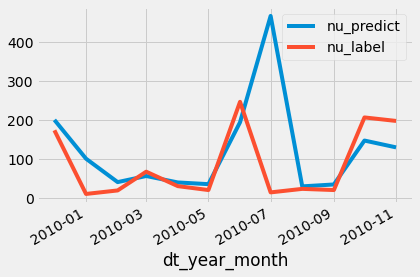

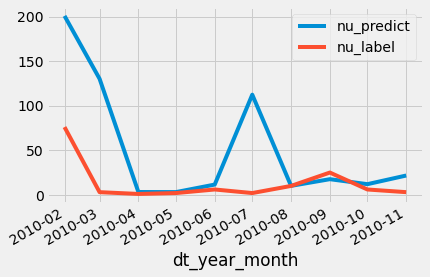

In [19]:
df_all_predictions[
    (df_all_predictions['StockCode'] == 90214) &
    (df_all_predictions['cd_model'] == 'random_forest')
].set_index('dt_year_month')['nu_predict'].plot(legend=True)
df_all_predictions[
    (df_all_predictions['StockCode'] == 90214) &
    (df_all_predictions['cd_model'] == 'random_forest')
].set_index('dt_year_month')['nu_label'].plot(legend=True)

plt.show()

df_all_predictions[
    (df_all_predictions['StockCode'] == 10124) &
    (df_all_predictions['cd_model'] == 'random_forest')
].set_index('dt_year_month')['nu_predict'].plot(legend=True)
df_all_predictions[
    (df_all_predictions['StockCode'] == 10124) &
    (df_all_predictions['cd_model'] == 'random_forest')
].set_index('dt_year_month')['nu_label'].plot(legend=True)

plt.show()


In [15]:
all_features = pd.read_pickle('../models/2023_01_25/model/features.pickle')
all_features

{'features': ['qt_sales_lag_1',
  'qt_sales_lag_2',
  'qt_sales_lag_3',
  'qt_sales_lag_4',
  'qt_sales_lag_5',
  'qt_sales_lag_6',
  'qt_sales_mavg_3',
  'qt_sales_mavg_6'],
 'index_cols': ['StockCode', 'dt_year_month'],
 'feature_importance': {'xgboost': {'qt_sales_mavg_3': 0.3672722,
   'qt_sales_lag_1': 0.14505334,
   'qt_sales_lag_4': 0.10685167,
   'qt_sales_lag_2': 0.10138771,
   'qt_sales_lag_3': 0.08836022,
   'qt_sales_mavg_6': 0.08027746,
   'qt_sales_lag_5': 0.06368071,
   'qt_sales_lag_6': 0.047116686},
  'random_forest': {'qt_sales_mavg_3': 0.28229347980946595,
   'qt_sales_lag_1': 0.28051856152866056,
   'qt_sales_lag_2': 0.12672923860247776,
   'qt_sales_mavg_6': 0.11587175220659994,
   'qt_sales_lag_3': 0.08057897538952576,
   'qt_sales_lag_4': 0.0565655457534619,
   'qt_sales_lag_5': 0.03680940401705059,
   'qt_sales_lag_6': 0.020633042692757612}}}

## Features Futuras

- **Cross Validation:** Para realizar cross validation em séries temporais devemos fazer um split train e test e posteriormente pegar amostras do treino, sempre aumentando o tamanho em relação ao tempo. Tomar cuidado em relação aos vários produtos. 
- **Cadeia de Markov:** Probabilidade de um evento acontecer dado um evento anterior, não importando a sequência anterior dos eventos
$$P(X_{n+1} = x | X_0, X_1, X_2, ..., X_n) = P(X_{n+1} = x | X_n)$$

- **Modelo Ensemble:** Utilizar a previsão de modelos estatísticos como ARIMA, SARIMA e suas variações ou até mesmo o Prophet para adicionar mais informações como sazonalidade e estacionaridade para o modelo de ML.